## VAE Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()

#         self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.input = nn.Linear(input_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)

#     def forward(self, x, label):
    def forward(self, x):
#         out = self.input(torch.cat((x, label), -1))
        out = self.input(x)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
#         out = self.hidden2(out)
#         out = F.relu(out)
        
#         out = self.hidden3(out)
#         out = F.relu(out)
        
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)

        return mu_z, std_z


class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()

#         self.input = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.input = nn.Linear(latent_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.2)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(0.5)
        
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)

#     def forward(self, z, label):
    def forward(self, z):
#         out = self.input(torch.cat((z, label), -1))
        out = self.input(z)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
#         out = self.hidden2(out)
#         out = F.relu(out)
        
#         out = self.hidden3(out)
# #         out = self.bn3(out)
#         out = F.relu(out)
# #         out = self.dropout3(out)
        
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)

        return mu_x, std_x

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch 
import pandas as pd 
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [3]:
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
print(len(bos.feature_names))
df["Price"] = bos.target

data = df[df.columns[:-1]]
# data = data.apply(
#     lambda x: (x - x.mean()) / x.std()
# )

data["Price"] = df.Price

13


In [4]:
from sklearn import preprocessing

# Dataset to numpy
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64)

# Split dataset for test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=42)

# Standardize 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

Y_train = Y_train.view(-1, 1)
Y_test = Y_test.view(-1, 1)

In [5]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [6]:
""" Hyperparameters """
N_EPOCHS = 1200    # N_EPOCHS = 100 overfitted the data so the evaluation was very bad 
BATCH_SIZE = 128
lr = 0.001
INPUT_DIM = X_train.shape[1]
LABEL_DIM = Y_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 5

In [7]:
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)

In [8]:
encoder = Encoder(INPUT_DIM, LABEL_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
decoder = Decoder(LATENT_DIM, LABEL_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [9]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=1e-7)

In [10]:
train_loss_avg = []


for ep in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x, y in train_iter:
        # Update the gradient to zero 
        optimizer.zero_grad()
        
        # Forward pass 
        # Encoder
#         mu_z, std_z = encoder(x, y)
        mu_z, std_z = encoder(x)

        # Sample z
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)

        # Decoder
#         mu_x, std_x = decoder(z_samples, y)
        mu_x, std_x = decoder(z_samples)
        eps = torch.randn_like(std_x)

#         x_samples = mu_x + eps * torch.exp(std_x)

#         return mu_z, std_z, z_samples, mu_x, std_x, x_samples
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward pass 
        loss.backward()
        
        # Update the weights 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    print("Epoch [%d / %d] average loss: %f" % (ep+1, N_EPOCHS, train_loss_avg[-1]))

Epoch [1 / 1200] average loss: 26.406805
Epoch [2 / 1200] average loss: 25.224725
Epoch [3 / 1200] average loss: 24.831125
Epoch [4 / 1200] average loss: 24.209398
Epoch [5 / 1200] average loss: 23.969907
Epoch [6 / 1200] average loss: 23.264534
Epoch [7 / 1200] average loss: 23.361533
Epoch [8 / 1200] average loss: 23.433758
Epoch [9 / 1200] average loss: 23.033748
Epoch [10 / 1200] average loss: 22.627295
Epoch [11 / 1200] average loss: 22.382054
Epoch [12 / 1200] average loss: 22.310230
Epoch [13 / 1200] average loss: 22.294955
Epoch [14 / 1200] average loss: 23.339211
Epoch [15 / 1200] average loss: 21.937635
Epoch [16 / 1200] average loss: 21.485581
Epoch [17 / 1200] average loss: 21.092985
Epoch [18 / 1200] average loss: 20.977804
Epoch [19 / 1200] average loss: 21.054885
Epoch [20 / 1200] average loss: 20.576433
Epoch [21 / 1200] average loss: 20.721725
Epoch [22 / 1200] average loss: 20.585021
Epoch [23 / 1200] average loss: 20.514753
Epoch [24 / 1200] average loss: 20.283401
E

Epoch [197 / 1200] average loss: 11.985279
Epoch [198 / 1200] average loss: 11.922760
Epoch [199 / 1200] average loss: 11.921980
Epoch [200 / 1200] average loss: 11.924852
Epoch [201 / 1200] average loss: 11.862714
Epoch [202 / 1200] average loss: 11.849190
Epoch [203 / 1200] average loss: 11.731482
Epoch [204 / 1200] average loss: 11.744509
Epoch [205 / 1200] average loss: 11.760388
Epoch [206 / 1200] average loss: 11.713326
Epoch [207 / 1200] average loss: 11.869435
Epoch [208 / 1200] average loss: 11.695315
Epoch [209 / 1200] average loss: 11.650538
Epoch [210 / 1200] average loss: 11.618343
Epoch [211 / 1200] average loss: 11.614196
Epoch [212 / 1200] average loss: 11.572542
Epoch [213 / 1200] average loss: 11.525927
Epoch [214 / 1200] average loss: 11.474477
Epoch [215 / 1200] average loss: 11.465654
Epoch [216 / 1200] average loss: 11.380088
Epoch [217 / 1200] average loss: 11.568031
Epoch [218 / 1200] average loss: 11.389073
Epoch [219 / 1200] average loss: 11.343541
Epoch [220 

Epoch [391 / 1200] average loss: 8.838122
Epoch [392 / 1200] average loss: 8.623154
Epoch [393 / 1200] average loss: 8.544654
Epoch [394 / 1200] average loss: 8.557303
Epoch [395 / 1200] average loss: 8.457361
Epoch [396 / 1200] average loss: 8.603274
Epoch [397 / 1200] average loss: 8.564075
Epoch [398 / 1200] average loss: 8.396221
Epoch [399 / 1200] average loss: 8.513498
Epoch [400 / 1200] average loss: 8.537832
Epoch [401 / 1200] average loss: 8.468931
Epoch [402 / 1200] average loss: 8.458978
Epoch [403 / 1200] average loss: 8.390063
Epoch [404 / 1200] average loss: 8.406846
Epoch [405 / 1200] average loss: 8.343619
Epoch [406 / 1200] average loss: 8.346237
Epoch [407 / 1200] average loss: 8.410314
Epoch [408 / 1200] average loss: 8.339794
Epoch [409 / 1200] average loss: 8.341620
Epoch [410 / 1200] average loss: 8.348155
Epoch [411 / 1200] average loss: 8.338117
Epoch [412 / 1200] average loss: 8.361978
Epoch [413 / 1200] average loss: 8.269771
Epoch [414 / 1200] average loss: 8

Epoch [589 / 1200] average loss: 7.345531
Epoch [590 / 1200] average loss: 7.297316
Epoch [591 / 1200] average loss: 7.122385
Epoch [592 / 1200] average loss: 6.972900
Epoch [593 / 1200] average loss: 7.080729
Epoch [594 / 1200] average loss: 7.017632
Epoch [595 / 1200] average loss: 7.012546
Epoch [596 / 1200] average loss: 7.056823
Epoch [597 / 1200] average loss: 7.127717
Epoch [598 / 1200] average loss: 6.947332
Epoch [599 / 1200] average loss: 7.027029
Epoch [600 / 1200] average loss: 6.791874
Epoch [601 / 1200] average loss: 6.846279
Epoch [602 / 1200] average loss: 6.873501
Epoch [603 / 1200] average loss: 6.799675
Epoch [604 / 1200] average loss: 6.781614
Epoch [605 / 1200] average loss: 6.765737
Epoch [606 / 1200] average loss: 6.785659
Epoch [607 / 1200] average loss: 6.675592
Epoch [608 / 1200] average loss: 6.724443
Epoch [609 / 1200] average loss: 6.729761
Epoch [610 / 1200] average loss: 6.860748
Epoch [611 / 1200] average loss: 6.685898
Epoch [612 / 1200] average loss: 6

Epoch [786 / 1200] average loss: 6.518998
Epoch [787 / 1200] average loss: 6.506805
Epoch [788 / 1200] average loss: 6.399354
Epoch [789 / 1200] average loss: 6.298135
Epoch [790 / 1200] average loss: 6.441119
Epoch [791 / 1200] average loss: 6.497748
Epoch [792 / 1200] average loss: 6.565375
Epoch [793 / 1200] average loss: 6.387376
Epoch [794 / 1200] average loss: 6.419604
Epoch [795 / 1200] average loss: 6.391353
Epoch [796 / 1200] average loss: 6.502334
Epoch [797 / 1200] average loss: 6.522868
Epoch [798 / 1200] average loss: 6.436440
Epoch [799 / 1200] average loss: 6.486436
Epoch [800 / 1200] average loss: 6.411929
Epoch [801 / 1200] average loss: 6.409799
Epoch [802 / 1200] average loss: 6.311867
Epoch [803 / 1200] average loss: 6.378559
Epoch [804 / 1200] average loss: 6.329113
Epoch [805 / 1200] average loss: 6.363561
Epoch [806 / 1200] average loss: 6.283564
Epoch [807 / 1200] average loss: 6.252429
Epoch [808 / 1200] average loss: 6.346856
Epoch [809 / 1200] average loss: 6

Epoch [983 / 1200] average loss: 6.127537
Epoch [984 / 1200] average loss: 5.951655
Epoch [985 / 1200] average loss: 5.912561
Epoch [986 / 1200] average loss: 6.036799
Epoch [987 / 1200] average loss: 5.837361
Epoch [988 / 1200] average loss: 5.926868
Epoch [989 / 1200] average loss: 5.970837
Epoch [990 / 1200] average loss: 5.834579
Epoch [991 / 1200] average loss: 5.971991
Epoch [992 / 1200] average loss: 5.961198
Epoch [993 / 1200] average loss: 6.085622
Epoch [994 / 1200] average loss: 5.826541
Epoch [995 / 1200] average loss: 5.982188
Epoch [996 / 1200] average loss: 5.949402
Epoch [997 / 1200] average loss: 6.018534
Epoch [998 / 1200] average loss: 6.007747
Epoch [999 / 1200] average loss: 6.009980
Epoch [1000 / 1200] average loss: 5.926203
Epoch [1001 / 1200] average loss: 5.982901
Epoch [1002 / 1200] average loss: 6.001913
Epoch [1003 / 1200] average loss: 5.845387
Epoch [1004 / 1200] average loss: 5.925999
Epoch [1005 / 1200] average loss: 5.945757
Epoch [1006 / 1200] average 

Epoch [1178 / 1200] average loss: 5.843653
Epoch [1179 / 1200] average loss: 5.717582
Epoch [1180 / 1200] average loss: 5.724061
Epoch [1181 / 1200] average loss: 5.739328
Epoch [1182 / 1200] average loss: 5.760456
Epoch [1183 / 1200] average loss: 5.723526
Epoch [1184 / 1200] average loss: 5.679513
Epoch [1185 / 1200] average loss: 5.729552
Epoch [1186 / 1200] average loss: 5.723931
Epoch [1187 / 1200] average loss: 5.780684
Epoch [1188 / 1200] average loss: 5.638280
Epoch [1189 / 1200] average loss: 5.676810
Epoch [1190 / 1200] average loss: 5.717866
Epoch [1191 / 1200] average loss: 5.694905
Epoch [1192 / 1200] average loss: 5.748381
Epoch [1193 / 1200] average loss: 5.603599
Epoch [1194 / 1200] average loss: 5.833039
Epoch [1195 / 1200] average loss: 5.737867
Epoch [1196 / 1200] average loss: 5.697594
Epoch [1197 / 1200] average loss: 5.719712
Epoch [1198 / 1200] average loss: 5.586596
Epoch [1199 / 1200] average loss: 5.636226
Epoch [1200 / 1200] average loss: 5.624747


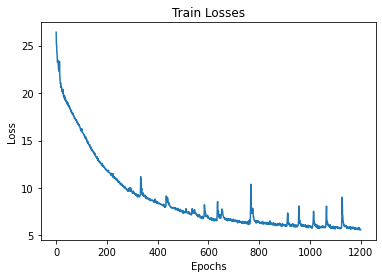

In [11]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.title("Train Losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Loss function 
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log q_\theta(z|x_i) - \log p_\phi(x_i|z) - \log p(z)]\\
= -\frac{1}{S} \sum_{i=1}^S [\mathcal{N}(z|\mu(x_i), \sigma(x_i))- \mathcal{N}(x_i|\mu(z), \sigma(z)) - \mathcal{N}(z|0, 1)]
$$
We add a negative sign to the loss function because the lower bound should be maximized while the loss function should be minimized.

### Test evaluation metrics
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log p_\phi(x_i|z)]\\
$$


Should I set $q_\theta(z|x_i)$ to $\mathcal{N}(z|0,1)$ if I am testing with $z\sim q(z)$? So the test evaluation would just be on the term $\log p_\phi(x_i|z)$.
I will be using my trained cVAE for predicting $x$ given just the label. It make sense to test in an environment same as how I will be using the model. So I should just find the error caused by the decoder. 

Referenced for loss function:
https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

Tutorial referenced:
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=LKnr0LCMhEGj

In [12]:
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [13]:
def eval_metrics(mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    loss = - (1 / S) * (torch.sum(log_p_x))
    
    return loss 

Sampling

In [14]:
S = X_test.shape[0]
# # Forward pass 
p_z_given_x = torch.distributions.Normal(0, 1)
z = p_z_given_x.sample((S, LATENT_DIM)).type(torch.float64)
# mu_x, std_x = decoder(z, Y_test)   
mu_x, std_x = decoder(z)

In [15]:
eps = torch.distributions.Normal(0, 1).sample(std_x.shape)
x_samples = mu_x + std_x * eps

In [16]:
x_samples.mean(0)

tensor([-0.3997, -0.2636, -0.2531, -0.0261,  0.0481, -0.0436,  0.0220, -0.0948,
         0.2626,  0.0272, -0.0483, -0.2977,  0.0638], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [17]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [18]:
x_samples.std(0)

tensor([3.5417, 3.5246, 3.2038, 0.2085, 1.6130, 0.5072, 1.2912, 1.3648, 2.3975,
        1.6875, 1.3139, 1.7532, 1.0312], dtype=torch.float64,
       grad_fn=<StdBackward1>)

In [19]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

Text(0, 0.5, 'Mean of Generated Distribution')

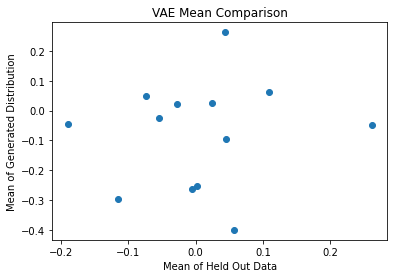

In [20]:
plt.scatter(X_test.mean(0).detach().numpy(), x_samples.mean(0).detach().numpy())
plt.title("VAE Mean Comparison")
plt.xlabel("Mean of Held Out Data")
plt.ylabel("Mean of Generated Distribution")

Text(0, 0.5, 'Standard Deviation of Generated Distribution')

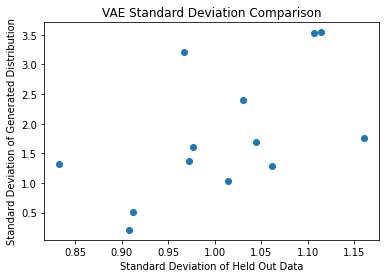

In [21]:
plt.scatter(X_test.std(0).detach().numpy(), x_samples.std(0).detach().numpy())
plt.title("VAE Standard Deviation Comparison")
plt.xlabel("Standard Deviation of Held Out Data")
plt.ylabel("Standard Deviation of Generated Distribution")

In [22]:
# figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
# for i in range(x_samples.shape[1]):
#     axs[i].scatter([x_test[:,i], x_samples[:,i]], color=['red','green'])
#     axs[i].legend(["data", "sample"])
# plt.show()

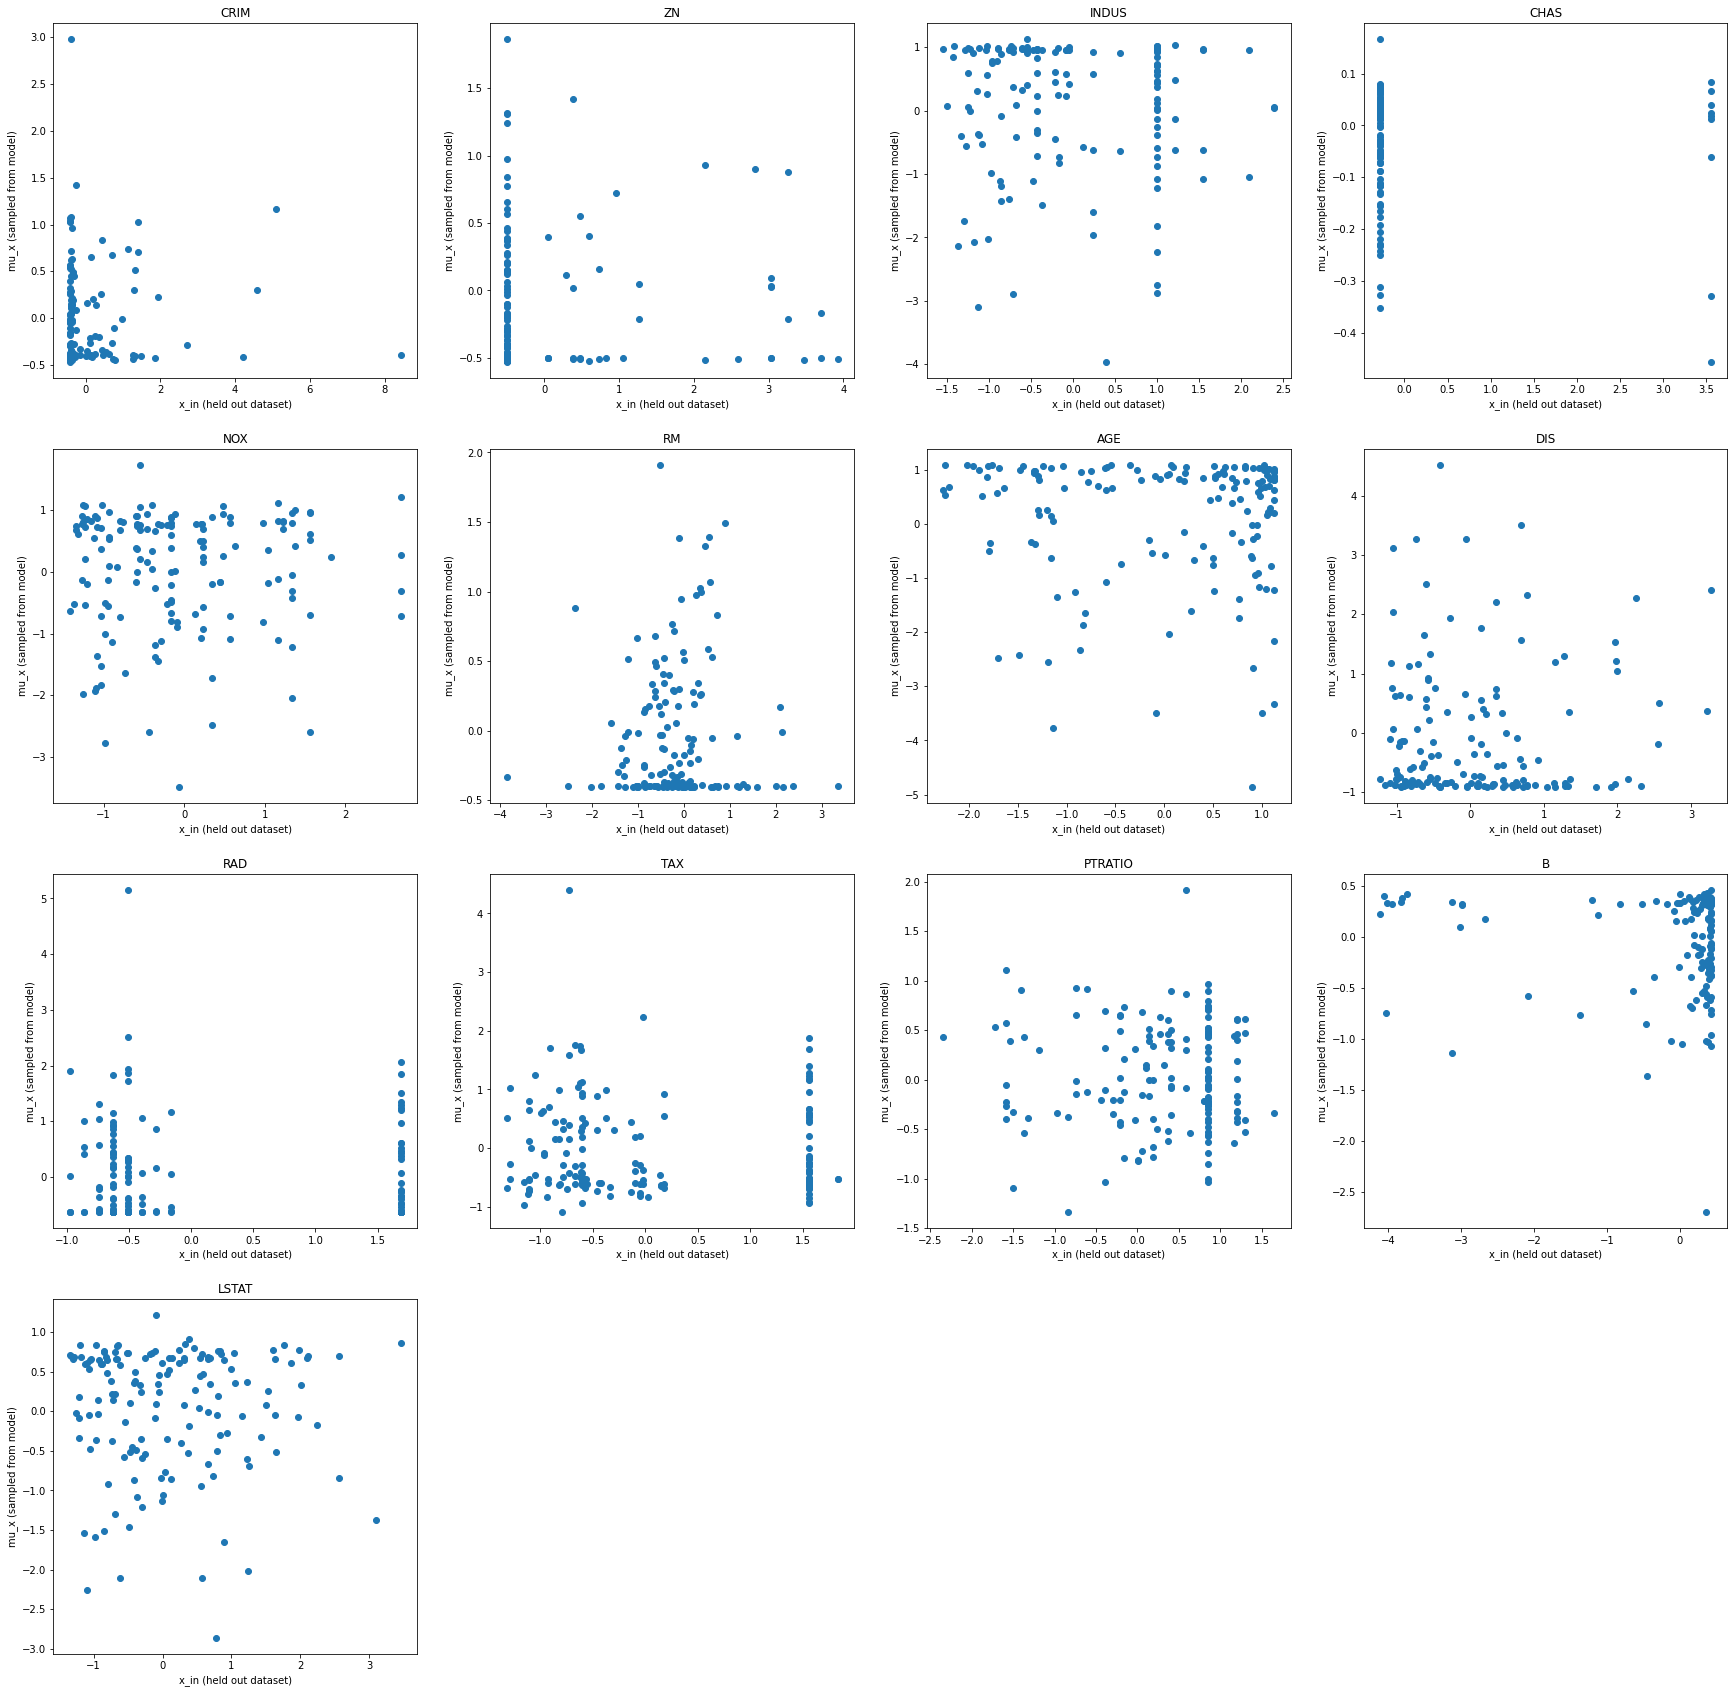

In [23]:
x_test = X_test.detach().numpy()
mu_x = mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(x_test[:,i*4+j], mu_x[:,i*4+j])
        axs[i, j].set_title(bos.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (sampled from model)")
        axs[i, j].set_xlabel("x_in (held out dataset)")
    if i*4+j >= 13: 
        break 

plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [24]:
X_test.shape

torch.Size([152, 13])

In [25]:
x_samples.shape

torch.Size([152, 13])

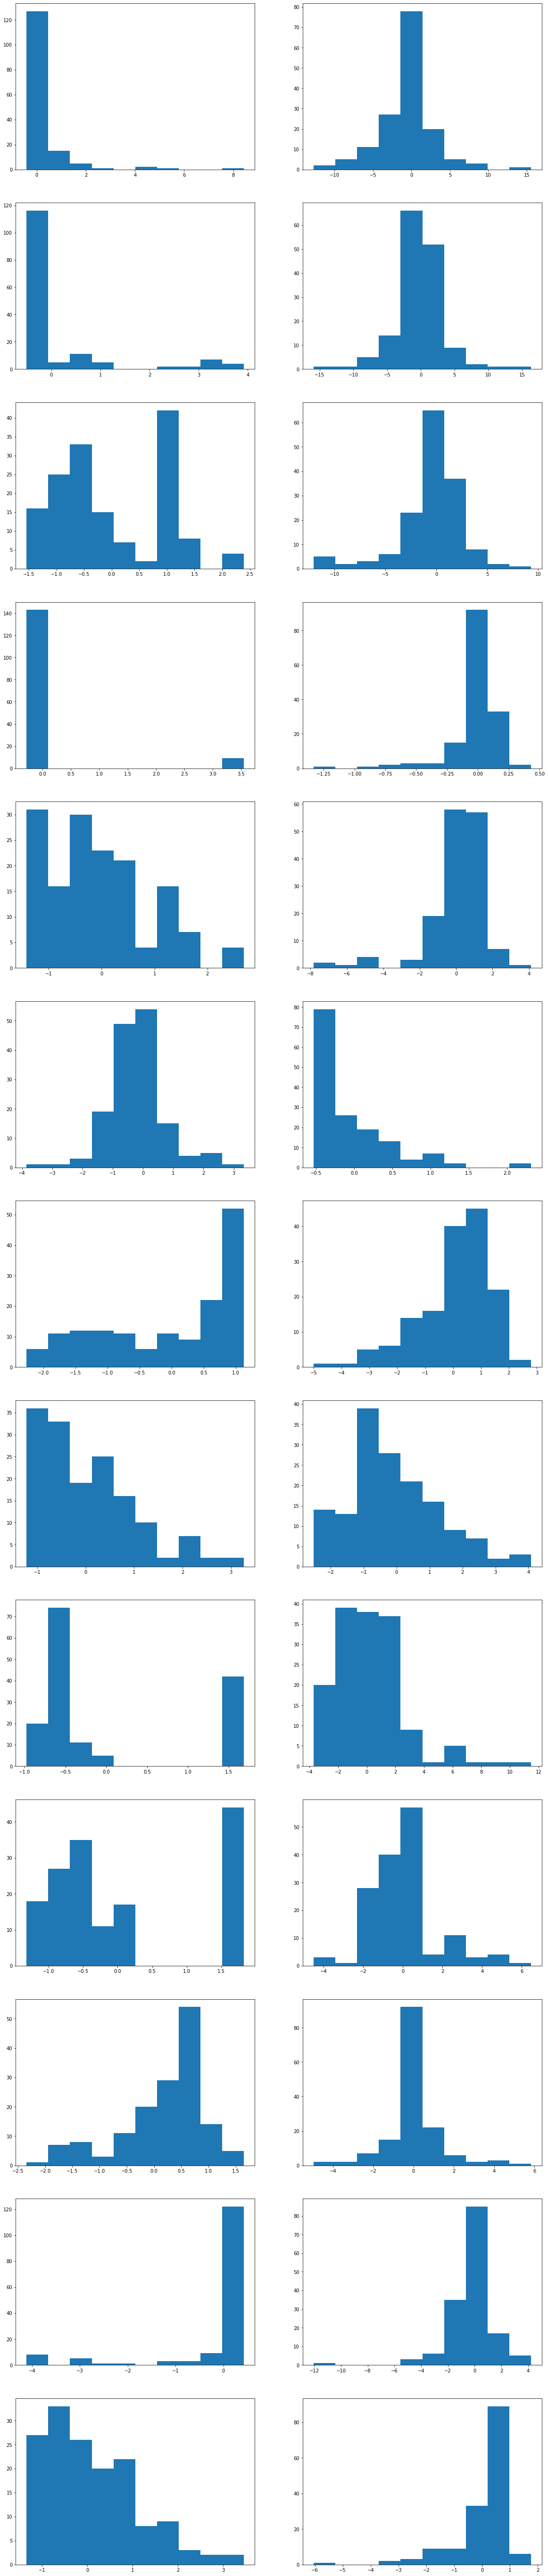

In [26]:
x_samples = x_samples.detach().numpy()
figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
for i in range(x_samples.shape[1]):
    axs[i, 0].hist(x_test[:,i])
    axs[i, 1].hist(x_samples[:,i])
plt.show()

In [27]:
x_samples.mean(0)

array([-0.39973438, -0.26355374, -0.25306374, -0.02612449,  0.04813977,
       -0.04360404,  0.02198519, -0.09482651,  0.2626328 ,  0.02720049,
       -0.04834311, -0.29765899,  0.06380434])

In [28]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [29]:
x_samples.std(0)

array([3.52999026, 3.51297943, 3.19328557, 0.20786042, 1.60769065,
       0.5055385 , 1.28696126, 1.3603007 , 2.38964345, 1.68191671,
       1.30961924, 1.74742846, 1.02779145])

In [30]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

1. What are the 13 features 
2. What does plotting the histogram represent. 

In [31]:
np.corrcoef(X_test, rowvar=False)[0]

array([ 1.        , -0.1910687 ,  0.42486438, -0.08718963,  0.46821577,
       -0.23795259,  0.38613771, -0.40293044,  0.63190985,  0.58463217,
        0.27942462, -0.52906495,  0.55059428])

In [32]:
np.corrcoef(x_samples, rowvar=False)[0]

array([ 1.        , -0.00137836,  0.05815698,  0.30620196,  0.17561126,
       -0.20307455,  0.19995696, -0.20091178,  0.13463192,  0.08742494,
        0.15148495,  0.09054386,  0.18402805])

In [33]:
np.corrcoef(X_test, rowvar=False)[1]

array([-0.1910687 ,  1.        , -0.51290453, -0.06876205, -0.49604812,
        0.34901083, -0.54269001,  0.65072851, -0.29812013, -0.33169892,
       -0.45453415,  0.18209134, -0.45634992])

In [34]:
np.corrcoef(x_samples, rowvar=False)[1]

array([-0.00137836,  1.        , -0.2386786 , -0.05648461, -0.00125366,
        0.1610468 , -0.16607478,  0.15370439, -0.02803619, -0.0811758 ,
       -0.091926  , -0.109039  , -0.10829585])

In [35]:
np.corrcoef(X_test, rowvar=False)[2]

array([ 0.42486438, -0.51290453,  1.        ,  0.03220062,  0.76409769,
       -0.35575224,  0.66757595, -0.72731343,  0.63361793,  0.7646962 ,
        0.45750608, -0.41160893,  0.66605524])

In [36]:
np.corrcoef(x_samples, rowvar=False)[2]

array([ 0.05815698, -0.2386786 ,  1.        ,  0.14301822,  0.02768992,
       -0.27984057,  0.3736022 , -0.35435806, -0.0802916 ,  0.02242284,
        0.00304032,  0.26948185,  0.07573913])

In [37]:
np.corrcoef(X_test, rowvar=False)[3]

array([-0.08718963, -0.06876205,  0.03220062,  1.        ,  0.06471079,
       -0.05183806,  0.09452797, -0.06774048, -0.14252854, -0.15269275,
       -0.21787821, -0.00468345,  0.07728061])

In [38]:
np.corrcoef(x_samples, rowvar=False)[3]

array([ 0.30620196, -0.05648461,  0.14301822,  1.        ,  0.56533543,
       -0.50272833,  0.52053243, -0.47379277,  0.19296767,  0.19027598,
        0.22118271,  0.11353207,  0.40261765])